In [79]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
from make_noise_updated import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [80]:
data0 = np.genfromtxt('../WFI2033_WFI.rdb',skip_header=2)
time0 = data0[:,0]
mag0_A=  data0[:,11]
mag0_B=  data0[:,18]
mag0_C=  data0[:,25]
#mag0_D=  data0[:,32]

# data1=np.genfromtxt('../DES0408_WFI.rdb',skip_header=2)
# time1 = data1[:,0]
# mag1_A=  data1[:,11]
# mag1_B=  data1[:,18]
# mag1_C=  data1[:,25]
# mag1_D=  data1[:,32]

In [81]:
mag0 = np.array([mag0_A,mag0_B,mag0_C])#,mag0_D])
#mag1 = np.array([mag1_A,mag1_B,mag1_D]) #mag1_C

In [82]:
# array = time0
# diff = np.array([])
# for i in range(1,len(array)):
#     diff = np.append(diff,array[i]-array[i-1])
# array[diff<30]

In [83]:
# plt.figure(figsize=(20,10))


# for i in range(3):#4): 
#     plt.plot(time0, mag0[i],'o')
# plt.show()

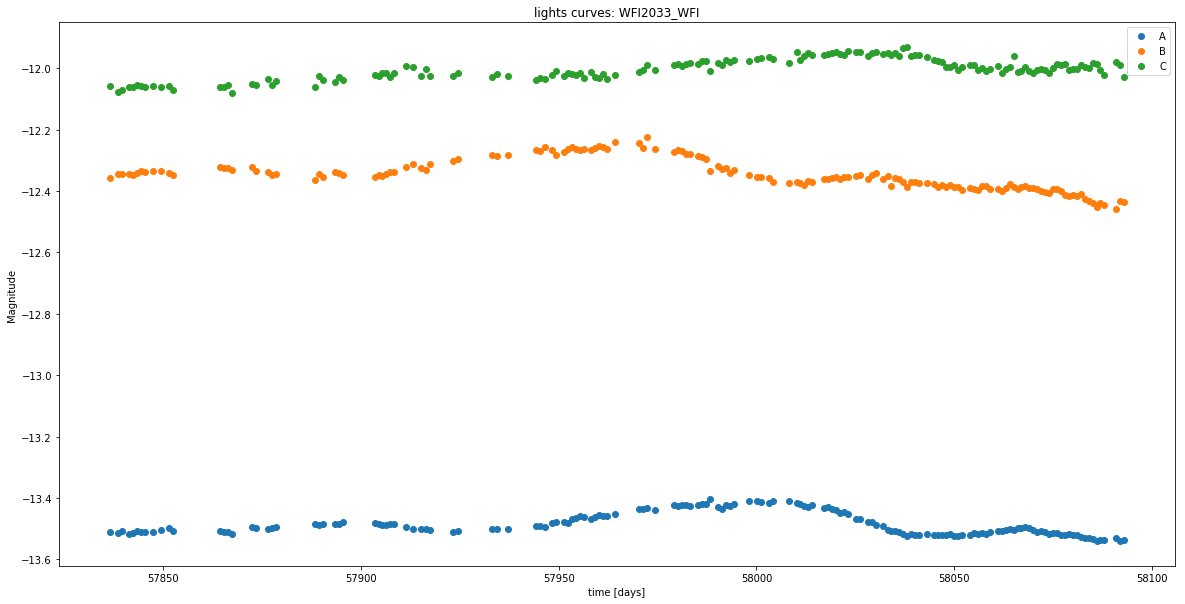

In [84]:
# for i in range(4): 
#     plt.plot(time0, mag0[i],'o')
# plt.show()


plt.figure(figsize=(20,10))
letter = np.array(['A','B','C'])
for i in range(3):#4): 
    plt.plot(time0, mag0[i],'o', label = letter[i])
plt.legend()
plt.title('lights curves: WFI2033_WFI')
plt.xlabel('time [days]')
plt.ylabel('Magnitude')
plt.show()



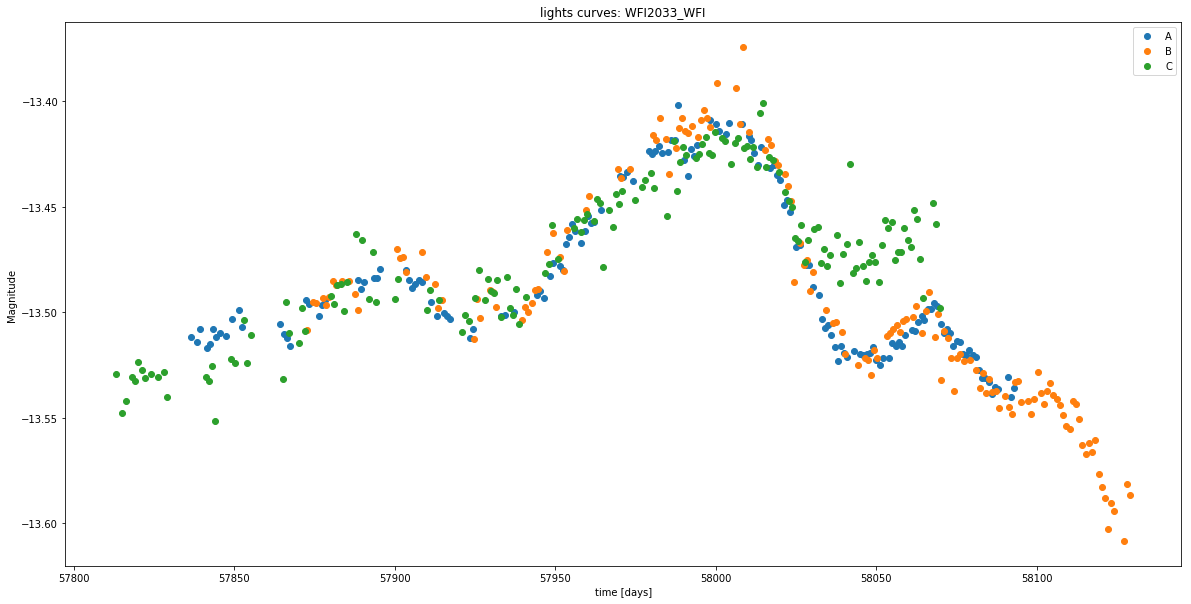

In [85]:

plt.figure(figsize=(20,10))
letter = np.array(['A','B','C'])
# for i in range(4):#4): 
plt.plot(time0, mag0[0],'o', label = letter[0])
plt.plot(time0+36.2, mag0[1]-1.15,'o', label = letter[1])
plt.plot(time0-23.3, mag0[2]-1.47,'o', label = letter[2])

plt.legend()
plt.title('lights curves: WFI2033_WFI')
plt.xlabel('time [days]')
plt.ylabel('Magnitude')
plt.show()

In [86]:


ts = time0 #gaps(time1)[1] #sim[0]+np.max(time_delays) # observation time sample (same for all curves= non_shifted)
time_delays = [0,-36.2,23.3] # A,B,D


sampling = 3
h=sampling
# desired sampling for each curve


tk = np.linspace(np.min(time0-23.3),np.max(time0+36.2),np.int(np.abs((np.min(ts)-np.max(ts))/h)),dtype=float,retstep=True)[0]  # [1] gives approx : h


matrix = []
for i in range(3):
    matrix.append(np.array([(ts[:,np.newaxis])+time_delays[i]- tk[np.newaxis,:]])) # change time_delays to dt # -dt
matrix = np.array(matrix)

A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2]],axis =0)/h) #matrix[3]],axis =0)/h) # 4 x s x K  , add h* to try

Y= np.concatenate([ mag0[0][np.newaxis,:],mag0[1][np.newaxis,:]-1.15,mag0[2][np.newaxis,:]-1.47])#,mag0[3][np.newaxis,:]]) # 4 x s
#print('A.shape: ', A.shape, '\nY.shape: ', Y.shape)

In [87]:
# plt.plot(sim[0], fs[0],'o')
# plt.plot(sim[0], fs[1]+0.1,'o')
# plt.plot(sim[0], fs[2]+0.3,'o')
# plt.plot(sim[0], fs[3]+0.5,'o')
# plt.show()

In [88]:
# multiplication functions:
#noise_std = sim[3]
def AT(X,A,Y): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xsxk, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    sum_ = 0
    for i in range(3):
        sum_ += np.dot(A[i].T, Y[i] - A[i] @ X)#*((1/noise_std[i])**2)
    
    return sum_#/np.sum(1/(noise_std**2))

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(3):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(3):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

In [89]:
def linorm(S, nit):
    x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
    x0 = x0 /np.linalg.norm(x0)
    for i in range(nit):
        x = multiplication(x0,S)#np.dot(x0,S)
        xn = np.linalg.norm(x)
        xp = x / xn#     
        y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
        yn = np.linalg.norm(y)  
        x0 = y / yn
    return 1./xn
mu = linorm(A,20)/170 # = 0.0038

X = np.zeros(len(tk))

count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3




In [90]:
max_var = np.abs(np.max((mag0_A[1:]-mag0_A[:-1])))#/(t[1:]-t[:-1]))) # exact if without noise (f doesnt have noise)

# with total variation


while np.logical_and(R[-1] > epsilon, count < 5000).all():  # 5000 is a good amount of counts
    X_new = X + mu * AT(X,A,Y)
    X = X_new.copy()   
    S_var = (X[:-1]-X[1:])#/((tk[:-1]-tk[1:]))
    sign = np.sign(S_var[np.abs(S_var) >2*max_var])
    loc = np.where(np.abs(S_var) >2*max_var)
    X[loc] = X[loc] - 2*max_var*sign
    
    count += 1

    R.append(np.sum((Y - A @ X) ** 2.))

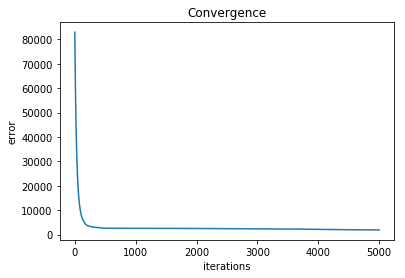

In [91]:
plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

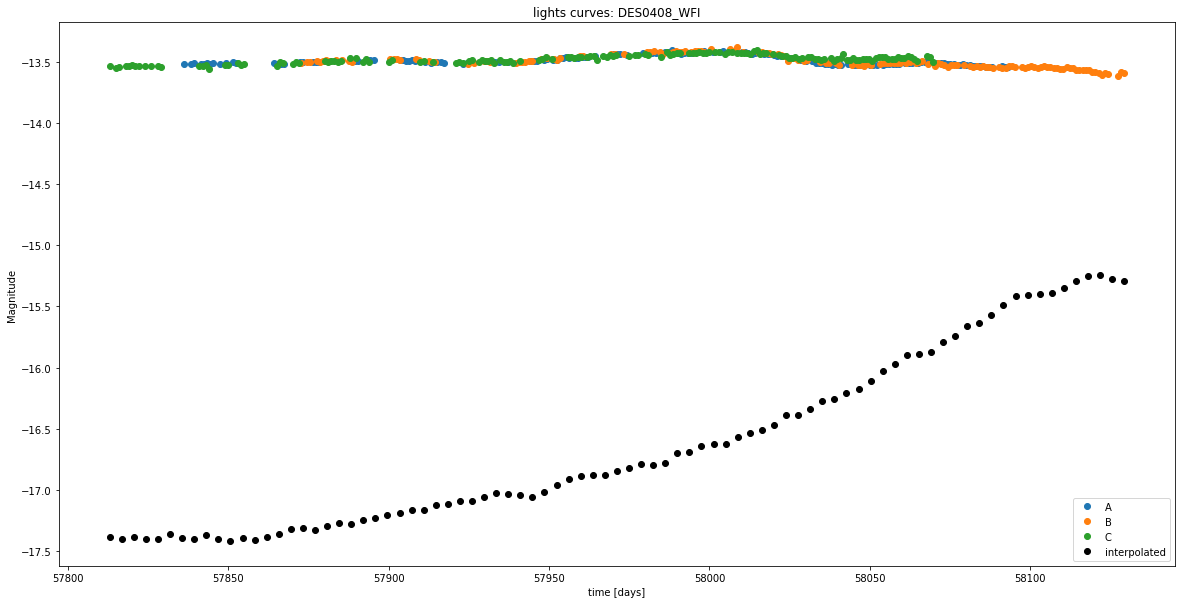

In [92]:
plt.figure(figsize=(20,10))
letter = np.array(['A','B','C'])
# for i in range(4):#4): 
cut = np.logical_and(X < np.max(Y), X > np.min(Y))
plt.plot(time0, mag0[0],'o', label = letter[0])
plt.plot(time0+36.2, mag0[1]-1.15,'o', label = letter[1])
plt.plot(time0-23.3, mag0[2]-1.47,'o', label = letter[2])
plt.plot(tk, X-0.5,'o', label='interpolated', color='black')

plt.legend()
plt.title('lights curves: DES0408_WFI')
plt.xlabel('time [days]')
plt.ylabel('Magnitude')
plt.show()






# %matplotlib qt
# #cut = np.logical_and(X < np.max(Y), X > np.min(Y))
# plt.figure(figsize=(20,10))

# for i in range(3):
#     plt.plot(ts, Y[i], 'o', label='light curve '+str(i))    

# #plt.plot(tk[cut], X[cut],'o', label='interpolated', color='black')
# plt.plot(tk, X,'o', label='interpolated', color='black')
# #plt.plot(t,f,'o', label = 'true')
# plt.xlabel('time[days]')
# plt.ylabel('magnitude')
# plt.title('sinc interpolated values')
# plt.legend()
# #plt.savefig("Real data #1 interpolation, with seasonal gaps")
# plt.show()
